In [ ]:
# Copyright 2023, Acadential, All rights reserved.

# 11-7. Learning Rate Scheduler

저희가 이론편에서 살펴보았던 Learning Rate Scheduler는 다음과 같습니다:

1. Step LR
2. Exponential LR
3. Cosine Annealing LR
4. Cosine Annealing with Warm Restarts LR
5. Reduce on Plateau LR
6. Chained scheduler (Linear scheduler with warmup)
7. Huggingface LR scheduler (Cosine schedule with warmup)

이번에는 이러한 Learning Rate Scheduler를 실제로 구현해보도록 하겠습니다.

## Pseudo Code

아래 코드는 Learning Rate Scheduler에 대한 Pseudo Code입니다.

In [ ]:
Pseudo Code
import torch 
from torch.optim import lr_scheduler
from torch.optim import SGD
# Pytorch의 LR scheduler들은 모두 공통적으로 optimizer을 첫번째 input으로 받는다.
optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(
    # 기본적으로 optimizer를 인자로 받음
    optimizer,
    # 그외에 specific 한 인자를 입력받게 됨.
    step_size=30,
    gamma=0.1
)
tbar = tqdm(dataset)

# LR scheduler의 step() 함수로 learning rate을 조정
# 참고로 LR scheduler의 종류에 따라 step 함수는 다른 입력 값을 필요로 함
# 스케줄러는 매 epoch의 끝에서 학습 및 validation이 끝난 후
# scheduler 메소드로 실행됩니다.
for epoch in tbar:
    train(...)
    validate(...)
    scheduler.step()
    

## Preliminary setup
1. import modules
2. define model
3. define function for getting the current learning rate.

In [1]:
import torch 
from torch import nn 
from torch.optim import lr_scheduler
from torch.optim import SGD

# Importing the model 
from src.model import NeuralNetwork

# Importing the dataloaders
from src.data import get_dataloaders

# Importing the training and testing functions
from src.train_val import train_loop, val_loop

import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Initiate model, loss function, and optimizer
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001)
# Define train and test dataloaders
train_dataloader, test_dataloader = get_dataloaders()

In [3]:
# Function for retrieving the learning rate from the optimizer.
# schedular가 learning rate을 어떻게 변화시키는지 확인하기 위해서 필요한
# 유틸리티 함수임.
def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

## Step LR

### Overview

역할: Step LR Scheduler은 step_size마다 Learning Rate에 gamma을 곱해줍니다.

즉, 아래 예시에서 step_size=30, gamma=0.1의 경우 매 30 epoch마다 learning rate을 1/10으로 줄여주는 것입니다.

In [4]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [5]:
# Step LR을 적용한 예시 코드
# 100 epoch을 실제로 학습을 돌리기에는 학습 시간이 걸리므로 실제로 돌려보지는 않고
# 다음 Cell에 있는 코드를 돌려서 Learning의 변화를 확인해보도록 하겠습니다.

train_loss_history = []
test_loss_history = []
test_acc_history = []

lr_list = []

for epoch in range(10):
    
    model.train()
    # Train Loop
    train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)
    
    model.eval()
    # Validation Loop
    test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)
    
    scheduler.step()  # Step LR의 경우, Epoch 마다 scheduler.step()을 호출해야 합니다.
    lr_list.append(get_lr(optimizer))

    

Test Loss: 2.2738: 100%|██████████| 157/157 [00:03<00:00, 41.71it/s]


In [6]:
# Step LR에서는 Learning Rate이 어떻게 변하는지 확인해보겠습니다.

lr_list = []
lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))
for epoch in tbar:
    # train(...)
    # validate(...)
    scheduler.step()
    lr_list.append(get_lr(optimizer))
    



100%|██████████| 100/100 [00:00<00:00, 103614.23it/s]


### Plotting LR w.r.t Epochs

Text(0, 0.5, 'LR')

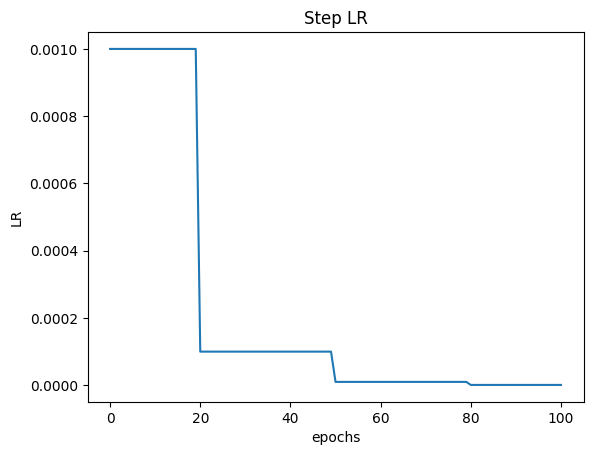

In [7]:
# 애폭 100번이 너무 오래걸리므로 
# 매 애폭마다 learning rate만 어떻게 변화하는지 보여줌

plt.figure()
plt.plot(lr_list)
plt.title("Step LR")
plt.xlabel("epochs")
plt.ylabel("LR")

## Exponential LR

### Overview

역할: Exponential LR은 매 epoch마다 Learning Rate에 gamma을 곱해줍니다.

즉, 아래 예시에서 gamma=0.9의 경우 매 epoch마다 learning rate에 0.9을 곱해줍니다.

In [8]:
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
# Exponential LR Scheduler을 적용한 예시 코드
# Step LR과 사용법이 동일합니다.
# 마찬가지로 학습 시간이 조금 걸리니 실제로 돌려보지는 않고 다음 Cell에 있는 코드만 실행해주세요.

train_loss_history = []
test_loss_history = []
test_acc_history = []

lr_list = []

for epoch in range(100):
    
    model.train()
    # Train Loop
    train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)
    
    model.eval()
    # Validation Loop
    test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)
    
    scheduler.step()  # Step LR의 경우, Epoch 마다 scheduler.step()을 호출해야 합니다.
    lr_list.append(get_lr(optimizer))

    

In [9]:
lr_list = []
lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))
for epoch in tbar:
    # train(...)
    # validate(...)
    scheduler.step()
    lr_list.append(get_lr(optimizer))
    

100%|██████████| 100/100 [00:00<?, ?it/s]


### Plotting LR w.r.t Epochs

Text(0, 0.5, 'LR')

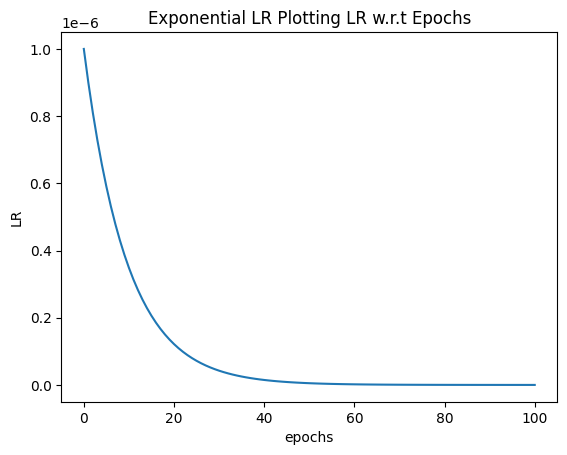

In [10]:
# 애폭 100번이 너무 오래걸리므로 
# 매 애폭마다 learning rate만 어떻게 변화하는지 보여줌

plt.figure()
plt.plot(lr_list)
plt.title("Exponential LR Plotting LR w.r.t Epochs")
plt.xlabel("epochs")
plt.ylabel("LR")

## Cosine Annealing LR

### Overview

역할: T_max의 주기를 가진 Cosine 함수로 Learning Rate을 scheduling합니다.

-  Optimizer에서 지정된 learning_rate이 곧 eta_max가 됩니다.
    - 즉, T_cur = N x T_max 때마다 learning_rate == eta_max.
- eta_min은 minimum learning rate입니다
    - 즉, T_cur = N x T_max + T_max // 2 때마다 learning_rate == eta_min.



In [19]:
optimizer = SGD(model.parameters(), lr=1e-4)

In [20]:
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                           T_max=2,
                                           eta_min=0)

In [ ]:
# Cosine Annealing LR Scheduler을 적용한 예시 코드
# Step LR과 사용법이 동일해서 Step LR을 참고하면 됩니다.

In [22]:
lr_list = []
lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))
for epoch in tbar:
    # train(...)
    # validate(...)
    scheduler.step()
    lr_list.append(get_lr(optimizer))
    

100%|██████████| 100/100 [00:00<00:00, 100270.24it/s]


### Plotting LR w.r.t Epochs

Text(0, 0.5, 'LR')

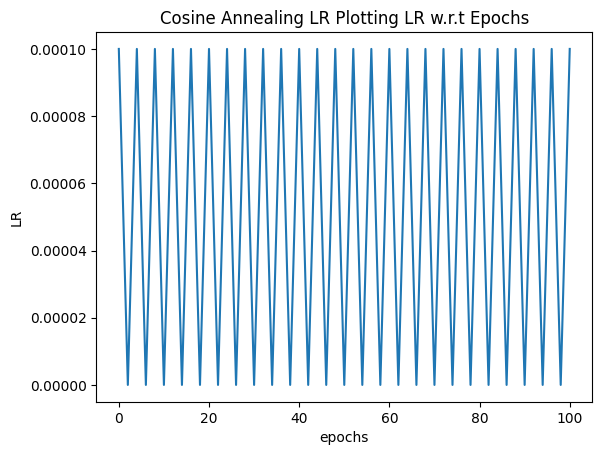

In [23]:
plt.figure()
plt.plot(lr_list)
plt.title("Cosine Annealing LR Plotting LR w.r.t Epochs")
plt.xlabel("epochs")
plt.ylabel("LR")

### Overview

역할: Cosine Annealing with Warm Restarts은 Cosine 함수로 줄어다가 다시 Max LR로 주기적으로 Restart하도록 Scheduling하는 방법입니다.

-  Optimizer에서 지정된 learning_rate이 곧 eta_max가 됩니다.
    - 즉, T_cur = N x T_max 때마다 learning_rate == eta_max.
- eta_min은 minimum learning rate입니다.
    - 즉, T_cur = N x T_max + T_max // 2 때마다 learning_rate == eta_min.

In [24]:
optimizer = SGD(model.parameters(), lr=1e-4)

In [25]:
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                     T_0=1,
                                                     T_mult=2,
                                                     eta_min=0)

In [ ]:
# Cosine Annealing LR with WarmRestarts Scheduler도
# Step LR과 사용법이 동일해서 Step LR을 참고하면 됩니다.
    

In [26]:
lr_list = []
lr_list.append(get_lr(optimizer))
tbar = tqdm(range(100))
for epoch in tbar:
    # train(...)
    # validate(...)
    scheduler.step()
    lr_list.append(get_lr(optimizer))
    

100%|██████████| 100/100 [00:00<00:00, 1295.31it/s]


### Plotting LR w.r.t Epochs

Text(0, 0.5, 'LR')

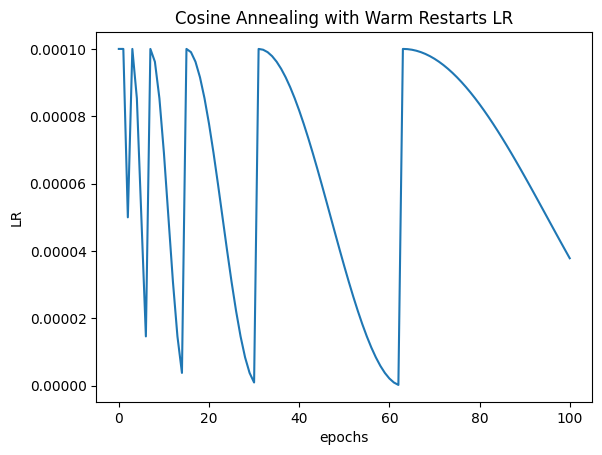

In [27]:
plt.figure()
plt.plot(lr_list)
plt.title("Cosine Annealing with Warm Restarts LR")
plt.xlabel("epochs")
plt.ylabel("LR")

## Reduce on Plateau LR

역할: Reduece on Plateau LR은 앞에서 살펴보았던 LR Scheduler와는 다르게 특정 조건이 만족되었을 때 LR을 감소시키는 방식입니다. 이 방식은 특정 epoch동안 성능이 향상되지 않을 때 LR을 감소시키는 방식입니다.

In [37]:
optimizer = SGD(model.parameters(), lr=1e-4)

In [38]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 
# mode란 모니터링 대상인 metric이 최소화 되는게 목표인지 최대화되는게 목표인지 명시
# 만약 모니터링 대상이 loss라면 최소화되어야 함으로 min이 맞다.
                                          mode="min", 
# facotr란 모니터링 대상이 개선되지 않을 떄 현재 learning rate에 곱해주는 수
                                          factor=0.1,
# patience epoch 갯수에 따라서 개선되지 않으면 learning rate을 조정해주는것
                                          patience=10,
# metric이 Threshold 이상 개선되어야 하고 개선되지 않으면 learning rate을 조정하는 것을의미
                                          threshold=0.0001,
                                          )

In [ ]:
# Reduce LR on Plateau을 Epoch 단위로 LR Scheduling 할시
# 기존의 Step LR Scheduler와 동일하게 사용됩니다.

train_loss_history = []
test_loss_history = []
test_acc_history = []

lr_list = []

for epoch in range(100):
    
    model.train()
    # Train Loop
    train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)
    
    model.eval()
    # Validation Loop
    test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)
    # Reduce LR on Plateau의 경우 test_loss를 인자로 넣어줍니다.
    scheduler.step(test_loss)  
    lr_list.append(get_lr(optimizer))

    

In [39]:
lr_list = []
lr_list.append(get_lr(optimizer))

loss_list = np.random.rand(100)

tbar = tqdm(range(100))
for epoch in tbar:
    # train(...)
    # validate(...)
    scheduler.step(loss_list[epoch])
    lr_list.append(get_lr(optimizer))
    

100%|██████████| 100/100 [00:00<?, ?it/s]


### Plotting Loss

Text(0.5, 0, 'epochs')

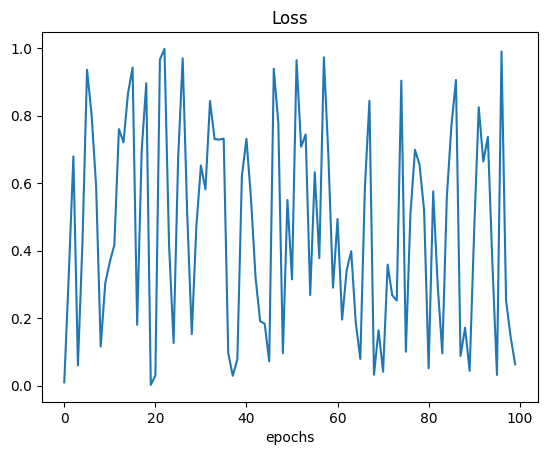

In [40]:
plt.figure()
plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("epochs")

### Plotting LR w.r.t Epochs

Text(0, 0.5, 'LR')

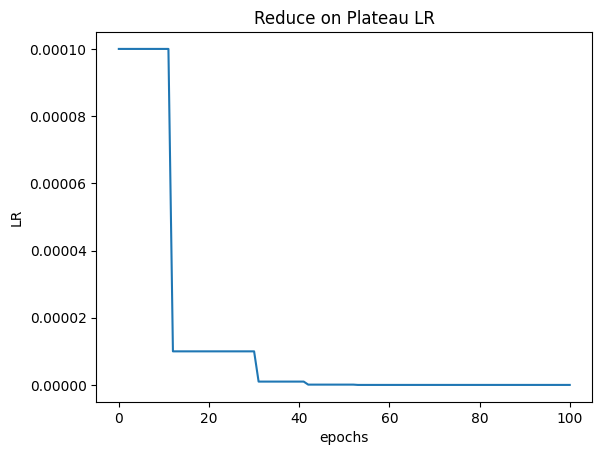

In [41]:
plt.figure()
plt.plot(lr_list)
plt.title("Reduce on Plateau LR")
plt.xlabel("epochs")
plt.ylabel("LR")

## Chained scheduler

### Overview

역할: 여러 Learning Rate scheduler들을 차례대로 수행하고 싶은 경우 Chained Scheduler을 사용할 수 있습니다.

###  Linear scheduler with warmup

다음과 같은 LR schedule을 만들고 싶다고 가정해보겠습니다:
- 먼저, Max Learning rate (1e-1)까지 Linear하게 10 epochs동안 증가했다가 (warmup 단계)
- 나머지 epoch들에서는 exponentially하게 decay하는 LR schedule을 만들고 싶은 경우를 가정해보겠습니다.

위 Schedule은 ChainedScheduler을 통해 다음과 같이 구현할 수 있습니다!

In [42]:
optimizer = SGD(model.parameters(), lr=1e-1)

In [43]:
lr_list = []
# 각각의 스케줄러들을 지정
scheduler1 = lr_scheduler.LinearLR(optimizer, 
                                   start_factor=0.1,
                                   end_factor=1.0,
                                   total_iters=10)

scheduler2 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# 스케줄러를 리스트로 묶어서 shcheduler의 인자로 넣음
scheduler = lr_scheduler.ChainedScheduler([scheduler1, scheduler2])
lr_list.append(get_lr(optimizer))
for epoch in tqdm(range(100)):
    # train(...)
    # validate(...)
    scheduler.step()
    lr_list.append(get_lr(optimizer))

100%|██████████| 100/100 [00:00<?, ?it/s]


### Plotting LR w.r.t Epochs

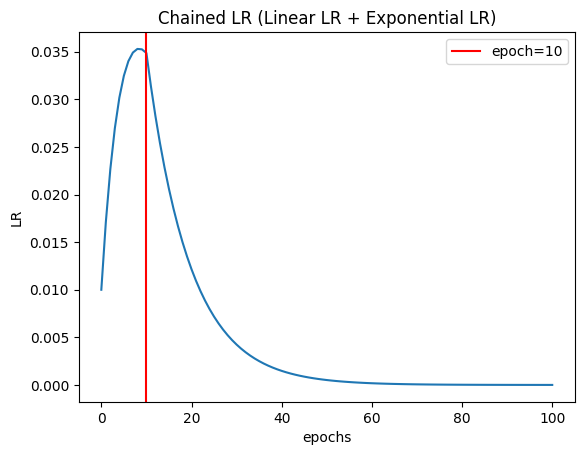

In [44]:
plt.figure()
plt.plot(lr_list)
plt.title("Chained LR (Linear LR + Exponential LR)")
plt.xlabel("epochs")
plt.ylabel("LR")### Plotting LR w.r.t Epochs
plt.axvline(10, color="r", label="epoch=10")
plt.legend()

## Huggingface LR scheduler (Cosine Schedule with Warmup)

### Overview

Huggingface에서도 다양한 LR scheduler들을 제공합니다! \
한 가지 예시로는 Cosine Schedule with warmup 스케쥴입니다. \
transformers 라이브러리를 pip install하면 transformers.optimization에서 다양한 scheduler들을 활용할 수 있습니다.

### Documentation

Documentation은 아래 링크에서 확인 가능합니다!

https://huggingface.co/docs/transformers/main_classes/optimizer_schedules

In [46]:
from transformers.optimization import get_cosine_schedule_with_warmup

In [47]:
optimizer = SGD(model.parameters(), lr=1e-4)
# get_cosine_schedule_with_warmup는 
# 먼저 Linear하게 learning rate이 증가하다가 cosine 함수로 감소시킵니다.
 
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=90,
)

In [48]:
lr_list = []
lr_list.append(get_lr(optimizer))
for epoch in tqdm(range(100)):
    # train(...)
    # validate(...)
    scheduler.step()
    lr_list.append(get_lr(optimizer))

100%|██████████| 100/100 [00:00<00:00, 100222.32it/s]


### Plotting LR w.r.t Epochs

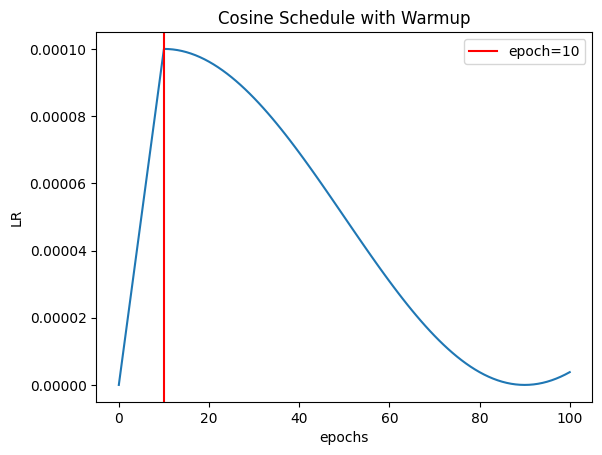

In [49]:
plt.figure()
plt.plot(lr_list)
plt.title("Cosine Schedule with Warmup")
plt.xlabel("epochs")
plt.ylabel("LR")
plt.axvline(10, color="r", label="epoch=10")
plt.legend()

# 참고 사항

학습할때 어떤 Learning Rate Scheduler가 최적의 Scheduler가 되는지는 알기 어렵습니다. \
따라서 Learning Rate Scheduler도 하나의 Hyperparameter로서 Grid Search와 같은 Hyperparameter Tuning을 통해서 최적의 Scheduler를 찾아야 합니다.